In [ ]:
from src.HestonModel import generate_heston_paths
import numpy as np
import esig
import matplotlib.pyplot as plt
import iisignature
import signatory
import torch
from tqdm.auto import tqdm

In [63]:
# constant Heston parameters
kappa = 3
theta = 0.02
v_0 = theta #
rho = 0.75
sigma = 0.6
r = 0.04

S = 100
paths = 10000
steps = 50
T = 1

In [ ]:
# Get Heston prices and volatilises
prices, sigs = generate_heston_paths(S, T, r, kappa, theta, v_0, rho, sigma, steps, paths, return_vol=True)

In [65]:
prices.shape

(10000, 50)

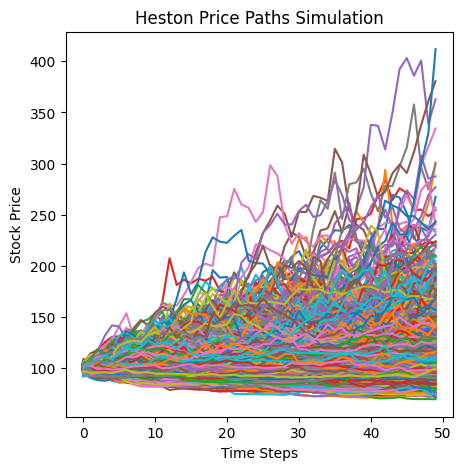

In [66]:
# Plot Heston Price paths
plt.figure(figsize=(5, 5))
plt.plot(prices.T)
plt.title('Heston Price Paths Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()


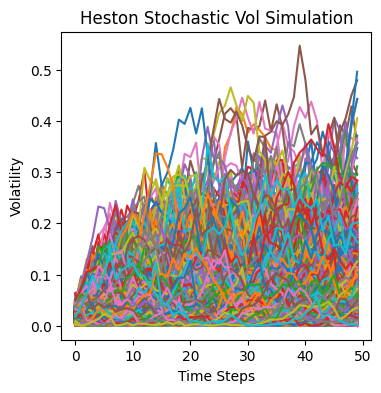

In [67]:
# Plot Heston volatility paths
plt.figure(figsize=(4, 4))
plt.plot(sigs.T)
plt.title('Heston Stochastic Vol Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.show()

In [7]:
thetas=np.arange(0.01,0.2,0.05)
kappas = np.arange(3,5)
v_0s = thetas #  = reversion_level
rhos = np.arange(0.1,1.1,0.3)
sigmas = np.arange(0.1,1.1,0.3)
rs = np.arange(0.01,0.10,0.03)

S = 100
paths = 10000
steps = 100
T = 1

In [8]:
depth_of_sig=2
width_of_sig=3  # prices + sigmas + time_array

In [9]:
sig_keys = esig.sigkeys(width_of_sig, depth_of_sig)
sig_dim=signatory.signature_channels(width_of_sig,depth_of_sig)

In [35]:
sig_keys

' () (1) (2) (3) (1,1) (1,2) (1,3) (2,1) (2,2) (2,3) (3,1) (3,2) (3,3)'

In [10]:
# define time_array and empty tensor for prices and sigmas, signatures and expected signatures
time_array = np.arange(steps)
prices_and_sigs_with_time_tensor = torch.zeros((paths,steps, width_of_sig ))
number_of_loops=thetas.shape[0]*kappas.shape[0]*rhos.shape[0]*sigmas.shape[0]*rs.shape[0]
sign_ps_signatory_differentranges=torch.zeros((number_of_loops,paths,sig_dim))
Exp_sign_signatory_results=torch.zeros((number_of_loops,sig_dim))
sign_ps_signatory_differentranges[0].shape

torch.Size([10000, 12])

In [11]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for r in tqdm(rs):
        for rho in rhos:
            for sigma in sigmas:
                for kappa in kappas:
                    for theta in thetas:
                        # Проблема в том, что каждый раз я генерирую новые prices из-за этого графики сильно меняются
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([512, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([512, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [ ]:
results_3=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_3=results_3[0]
Exp_signatures_results_3=results_3[1]

In [18]:
Exp_signatures_results_3.shape

torch.Size([512, 12])

In [49]:
signatures_results_3.shape

torch.Size([512, 10000, 12])

In [54]:
signatures_results_3[0].shape

torch.Size([10000, 12])

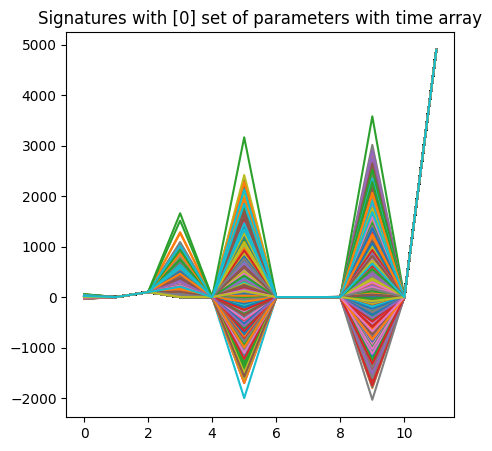

In [48]:
plt.figure(figsize=(5, 5))
plt.plot(signatures_results_3[0].T)  #there are 512 sets of parameters
plt.title("Signatures with [0] set of parameters with time array")
plt.show()

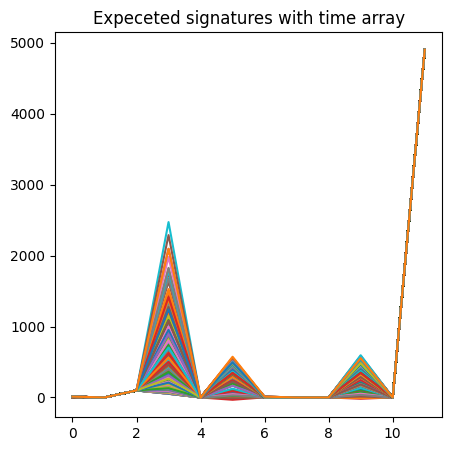

In [47]:
plt.figure(figsize=(5, 5))
plt.plot(Exp_signatures_results_3.T)
plt.title("Expeceted signatures with time array")
plt.show()

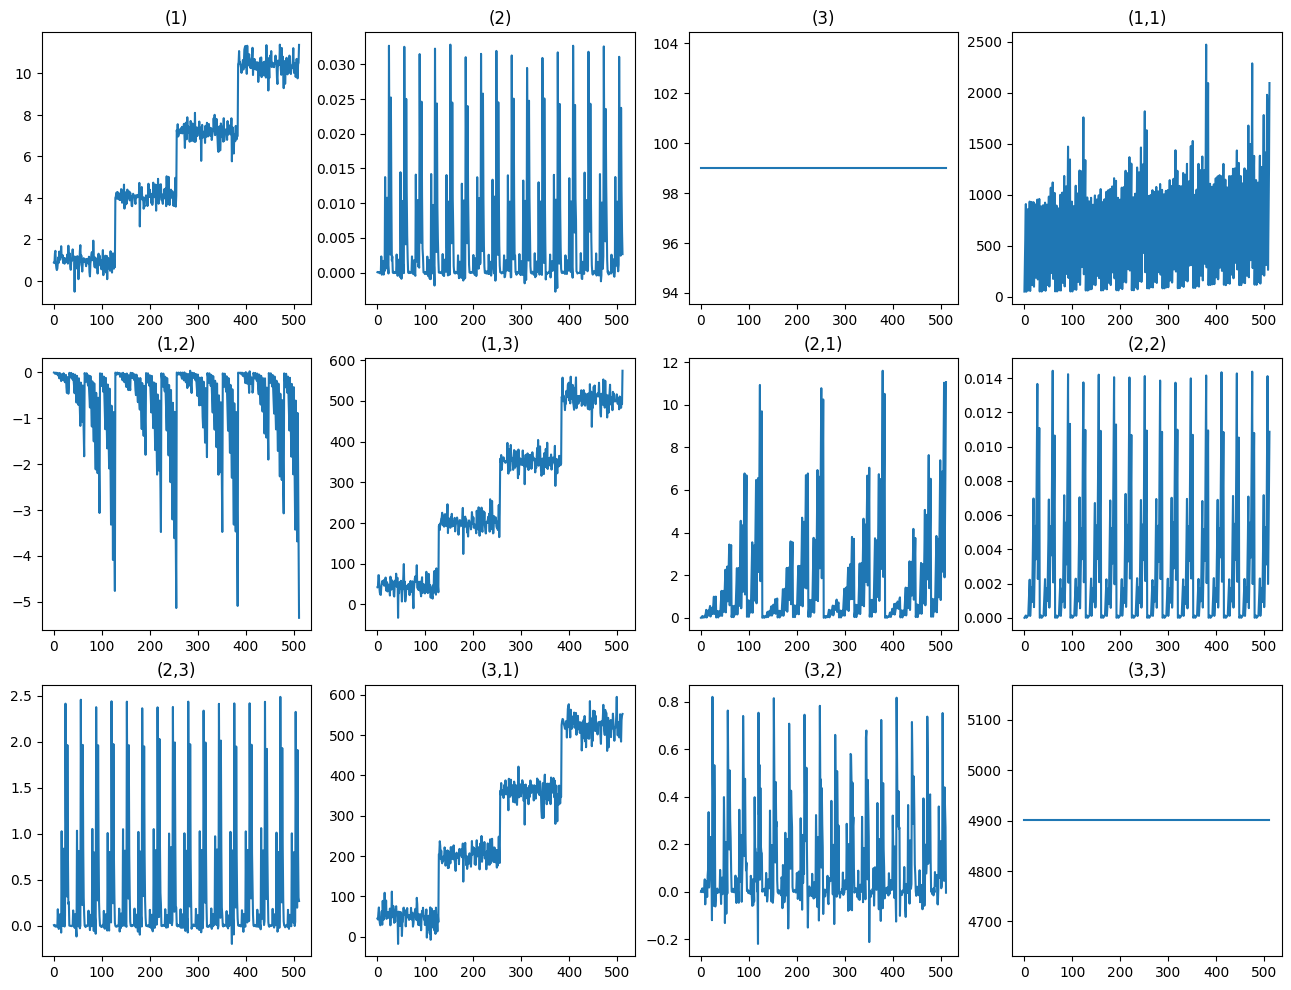

In [42]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_3.T[i])

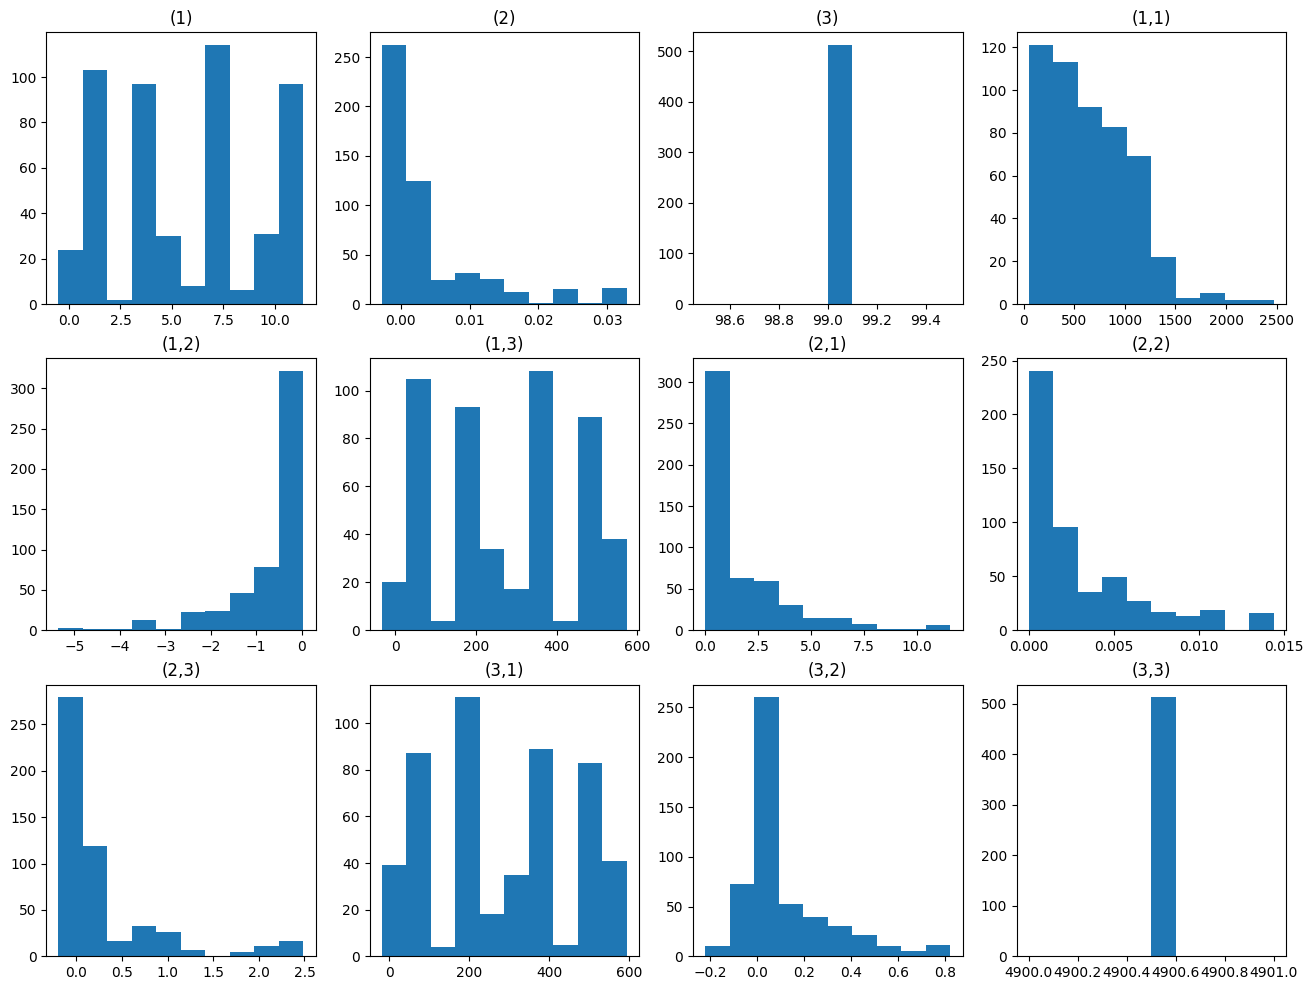

In [43]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.hist(Exp_signatures_results_3.T[i])